# Training the electric network

Write a two-layer neural network to train image in raw format. The network is trained to predict the electric network from the image. The network is trained on the training set and evaluated on the test set. The network is trained using stochastic gradient descent with a fixed learning rate and no regularization.

In [2]:
# import the necessary packages
import torch as torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# from torchviz import make_dot
# import raw image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os


## 1. transform the raw images to tensors

In [3]:
def rawimage2tensor(raw_data, width=32, height=32):
    # create a PIL image from the raw data
    img = Image.frombytes('I;16', (width, height), raw_data, decoder_name='raw')

    # convert the PIL image to a numpy array
    image = np.array(img)

    # convert uint16 to float32
    image = image.astype(np.float32)

    # flatten image to 1D array
    image = image.flatten()

    # convert the numpy array to a tensor
    tensor = torch.from_numpy(image)

    # return the tensor
    return tensor

### 1.1 read the image

In [4]:
# # open the raw image file
# with open('test_image/pic_20231025_15 1 2_991.raw', 'rb') as f:
#     # read the raw image data
#     raw_data = f.read()

# initialize the dataset
dataset = []

# open the raw image file in folder '红外光测试'
for image in os.listdir('红外光测试/img32x32_20231023_113512_flight/'):
    with open('红外光测试/img32x32_20231023_113512_flight/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 0  # 0 for flight
        # append the image tensor into dataset
        dataset.append((matrix, label))

for image in os.listdir('红外光测试/img32x32_20231023_113737_oil/'):
    with open('红外光测试/img32x32_20231023_113737_oil/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 1  # 1 for oil-tank
        # append the image tensor into dataset
        dataset.append((matrix, label))

for image in os.listdir('红外光测试/img32x32_20231023_113921_boat/'):
    with open('红外光测试/img32x32_20231023_113921_boat/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 2  # 2 for boat
        # append the image tensor into dataset
        dataset.append((matrix, label))

## 2. make a dataset
3 kinds of objects in 3 folders, 250 raw images in each folder, labeled as 0, 1, 2.

`datasets.ImageFolder(root='./data', transform=transform)` do not support raw image, so we need to make a dataset by ourselves.

### 2.1 load a dataset

In [5]:
print(len(dataset))
print(dataset[0][0].shape)
# check a random sample in dataset
sample = dataset[0]
print(sample[0], sample[1])
# plt.imshow(sample[0], cmap='gray')

# make random order of dataset samples
np.random.shuffle(dataset)

# split the dataset into training set and test set
train_dataset = dataset[:int(0.867*len(dataset))]
test_dataset = dataset[int(0.867*len(dataset)):]
print(len(train_dataset), len(test_dataset))

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


750
torch.Size([1024])
tensor([4268., 4277., 4430.,  ..., 4204., 2941., 2878.]) 0
650 100


### 2.2 check the dataset

0 torch.Size([10, 1024]) torch.Size([10]) 
 tensor([[4602., 4477., 4293.,  ..., 4570., 2896., 2963.],
        [4393., 4525., 4796.,  ..., 3436., 2920., 2729.],
        [3016., 2949., 2909.,  ..., 5113., 3060., 2900.],
        ...,
        [4681., 4650., 4654.,  ..., 5114., 3070., 3017.],
        [3195., 3291., 3250.,  ..., 4847., 2902., 2740.],
        [4202., 4235., 4322.,  ..., 5264., 3079., 2931.]]) tensor([0, 1, 1, 0, 2, 2, 1, 0, 2, 1])


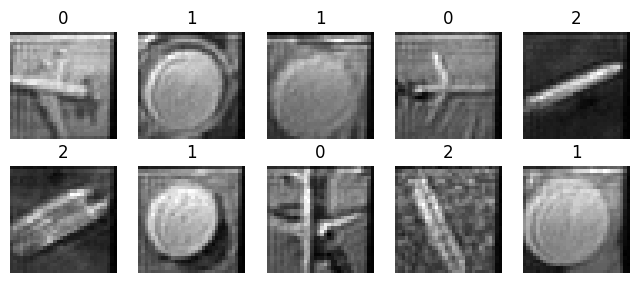

In [18]:
for batch, (X, y) in enumerate(train_dataloader):
    print(batch, X.shape, y.shape, '\n',
            X, y)
    break

# plot the 5 images in the first batch
plt.figure(figsize=(8, 3.2))
for i in range(batch_size):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i].reshape(32, 32), cmap='gray')
    plt.title(y[i].item())
    plt.axis('off')

## 3. define the network

The input tensor is a 32 * 32 raw image and flatten to 1 * 1024.

The weight value in the 1st layer should be binary (+1 or -1), the dimension of the weight matrix is 1024*32. The activation function is relu function.

The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. The output is 1 *3 matrix. The activation function is softmax function.

In [7]:
# define the network
# The weight value in the 1st layer should be binary (+1 or -1), 
# the dimension of the weight matrix is 1024*32. The activation function is relu function.
# The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. 
# The output is 1 *3 matrix. The activation function is softmax function.

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:

# Assume that `net` is your model and `x` is a sample input that your model expects.
net = Network()
x = torch.randn(1, 1024)  # Adjust the size of x according to your input tensor shape
y = net(x)

# Create a visualization of the forward pass through your net.
dot = make_dot(y.mean(), params=dict(net.named_parameters()))
dot.format = 'png'
dot.render("network_structure")

NameError: name 'make_dot' is not defined

## 4. train the network

In [9]:
model = Network()
print(model)

learning_rate = 5e-3

loss_fn = nn.CrossEntropyLoss()
print(loss_fn)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(optimizer)

Network(
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)
CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 605.142761  [   10/  650]
loss: 1.090137  [  210/  650]
loss: 1.093685  [  410/  650]
loss: 1.099500  [  610/  650]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.470298 

Epoch 2
-------------------------------
loss: 1.092868  [   10/  650]
loss: 1.091281  [  210/  650]
loss: 1.093071  [  410/  650]
loss: 1.100199  [  610/  650]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.470564 

Epoch 3
-------------------------------
loss: 1.093163  [   10/  650]
loss: 1.092427  [  210/  650]
loss: 1.092557  [  410/  650]
loss: 1.100895  [  610/  650]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.470855 

Epoch 4
-------------------------------
loss: 1.093475  [   10/  650]
loss: 1.093512  [  210/  650]
loss: 1.092128  [  410/  650]
loss: 1.101575  [  610/  650]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.471161 

Epoch 5
-------------------------------
loss: 1.093796  [   10/  650]
loss: 1.094533  [  210/  650]
loss: 1.091769  [  410/  650]
loss: 1.102230  [  6